In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import truncnorm

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

# For reproducibility only
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def merge_data(
    data: list
) -> list:
    '''
    Merges the data from multiple clients into a single dataset.

    Args:
        data (list): A list of dictionaries where each dictionary contains the features and labels for each client (output of previous functions).
    
    Returns:
        list: A list of four torch.Tensors containing the training features, training labels, testing features, and testing labels.
    
    '''
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    for client_data in data:
        train_features.append(client_data['train_features'])
        train_labels.append(client_data['train_labels'])
        test_features.append(client_data['test_features'])
        test_labels.append(client_data['test_labels'])

    # Concatenate all the data
    train_features = torch.cat(train_features, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    test_features = torch.cat(test_features, dim=0)
    test_labels = torch.cat(test_labels, dim=0)

    return [train_features, train_labels, test_features, test_labels]

def draw_split_statistic(
    data_list: torch.Tensor,
    plot_indices = None
) -> None:
    '''
    Print label counts and plot images.
    
    Args:
        data_list (list): A list of dictionaries where each dictionary contains the features and labels for each client.
                        * Output of split_ fns
        plot_indices (list): A list of indices to plot the first 100 images for each client.

    Warning:
        Working for only 10 classes dataset. (EMNIST e CIFAR100 NOT SUPPORTED)
    '''
    # Print label counts for each dictionary
    for i, data in enumerate(data_list):
        train_labels = data['train_labels']
        test_labels = data['test_labels']
        
        train_label_counts = torch.tensor([train_labels.tolist().count(x) for x in range(10)])
        test_label_counts = torch.tensor([test_labels.tolist().count(x) for x in range(10)])
        
        print(f"Client {i}:")
        print("Training label counts:", train_label_counts)
        print("Test label counts:", test_label_counts)
        print("\n")
    
    # If plot_indices is provided, plot the first 100 images with labels for the specified dictionaries
    if plot_indices:
        for idx in plot_indices:
            if idx < len(data_list):
                data = data_list[idx]
                train_features = data['train_features']
                train_labels = data['train_labels']
                
                num_images = min(100, train_features.shape[0])
                fig, axes = plt.subplots(10, 10, figsize=(15, 15))
                fig.suptitle(f'Dictionary {idx} - First {num_images} Training Images', fontsize=16)
                
                for i in range(num_images):
                    ax = axes[i // 10, i % 10]
                    image = train_features[i]
                    
                    if image.shape[0] == 3:
                        # For CIFAR (3, H, W) -> (H, W, 3)
                        image = image.permute(1, 2, 0).numpy()
                    else:
                        # For MNIST (1, H, W) -> (H, W)
                        image = image.squeeze().numpy()
                    
                    ax.imshow(image, cmap='gray' if image.ndim == 2 else None)
                    ax.set_title(train_labels[i].item())
                    ax.axis('off')
                
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

def load_full_datasets(
    dataset_name: str = "MNIST",
) -> list:
    '''
    Load datasets into four separate parts: train labels, train images, test labels, test images.

    Args:
        dataset_name (str): Name of the dataset to load. Options are "MNIST", "FMNIST", "EMNIST", "CIFAR10", "CIFAR100".

    TODO: EMNIST IS NOT WELL.

    Returns:
        list: [4] of torch.Tensor. [train_images, train_labels, test_images, test_labels]
    '''
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "EMNIST": # not auto-downloaded successfully
        train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, 
                                            transform = transforms.Compose([ 
                                            lambda img: transforms.functional.rotate(img, -90), 
                                            lambda img: transforms.functional.hflip(img), 
                                            transforms.ToTensor()
                                            ])
                                        )               
        test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True,
                                            transform = transforms.Compose([ 
                                            lambda img: transforms.functional.rotate(img, -90), 
                                            lambda img: transforms.functional.hflip(img), 
                                            transforms.ToTensor()
                                            ])
                                        )         
    elif dataset_name == "CIFAR10":
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR100":
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Dataset {dataset_name} is not supported.")

    # Extracting train and test images and labels
    train_images = torch.stack([data[0] for data in train_dataset]).squeeze(1)
    test_images = torch.stack([data[0] for data in test_dataset]).squeeze(1)
    
    if dataset_name in ["CIFAR10", "CIFAR100"]:
        train_labels = torch.tensor(train_dataset.targets).clone().detach()
        test_labels = torch.tensor(test_dataset.targets).clone().detach()
    else:
        train_labels = train_dataset.targets.clone().detach()
        test_labels = test_dataset.targets.clone().detach()

    return [train_images, train_labels, test_images, test_labels]

def rotate_dataset(
    dataset: torch.Tensor,
    degrees: list
) -> torch.Tensor:
    '''
    Rotates all images in the dataset by a specified degree.

    Args:
        dataset (torch.Tensor): Input dataset, a tensor of shape (N, ) where N is the number of images.
        degrees (list) : List of degrees to rotate each image.

    Returns:
        torch.Tensor: The rotated dataset, a tensor of the same shape (N, ) as the input.
    '''

    if len(dataset) != len(degrees):
        raise ValueError("The length of degrees list must be equal to the number of images in the dataset.")
    
    rotated_images = []
    
    for img_tensor, degree in zip(dataset, degrees):
        # Convert the tensor to a PIL image
        img = transforms.ToPILImage()(img_tensor)
        
        # Rotate the image
        rotated_img = img.rotate(degree)
        
        # Convert the PIL image back to a tensor
        rotated_img_tensor = transforms.ToTensor()(rotated_img).squeeze(0)
        
        rotated_images.append(rotated_img_tensor)
    
    # Stack all tensors into a single tensor
    rotated_dataset = torch.stack(rotated_images)
    
    return rotated_dataset

def color_dataset(
    dataset: torch.Tensor,
    colors: list
) -> torch.Tensor:
    '''
    Colors all images in the dataset by a specified color.

    Args:
        dataset (torch.Tensor): Input dataset, a tensor of shape (N, H, W) or (N, 3, H, W)
                                where N is the number of images.
        colors (list) : List of 'red', 'green', 'blue'， 'gray'.

    Warning:
        MNIST, FMNIST, EMNIST are 1-channel. CIFAR10, CIFAR100 are 3-channel.

    Returns:
        torch.Tensor: The colored dataset, a tensor of the shape (N, 3, H, W) with 3 channels.
    '''

    if len(dataset) != len(colors):
        raise ValueError("The length of colors list must be equal to the number of images in the dataset.")

    if dataset.dim() == 3:
        # Handle 1-channel dataset
        colored_dataset = dataset.unsqueeze(1).repeat(1, 3, 1, 1) # Shape becomes (N, 3, H, W)
    elif dataset.dim() == 4 and dataset.size(1) == 3:
        colored_dataset = dataset.clone()
    else:
        raise ValueError("This function only supports 1-channel (N, H, W) or 3-channel (N, 3, H, W) datasets.")

    for i, color in enumerate(colors):
        # Map the grayscale values to the specified color
        if color == 'red':
            colored_dataset[i, 0, :, :] = 1  # Set the red channel for the image
        elif color == 'green':
            colored_dataset[i, 1, :, :] = 1  # Set the green channel for the image
        elif color == 'blue':
            colored_dataset[i, 2, :, :] = 1  # Set the blue channel for the image
        elif color == "gray":
            pass
        else:
            raise ValueError("Color must be 'red', 'green', or 'blue'")

    return colored_dataset

def split_basic(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        permute (bool): Whether to shuffle the data before splitting.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]
    
    # Calculate the number of samples per client
    samples_per_client = len(features) // client_number
    
    # List to hold the data for each client
    client_data = []
    
    for i in range(client_number):
        start_idx = i * samples_per_client
        end_idx = start_idx + samples_per_client
        
        # Handle the last client which may take the remaining samples
        if i == client_number - 1:
            end_idx = len(features)
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
    
    return client_data

def split_unbalanced(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    std_dev: float = 0.1,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters unbalanced (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the data before splitting.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."
    assert std_dev > 0, "Standard deviation must be larger than 0."

    # Generate random percentage from a truncated normal distribution
    percentage = truncnorm.rvs(-0.5/std_dev, 0.5/std_dev, loc=0.5, scale=std_dev, size=client_number)
    normalized_percentage = percentage / np.sum(percentage)

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]

    # Calculate the number of samples per client based on the normalized samples
    total_samples = len(features)
    samples_per_client = (normalized_percentage * total_samples).astype(int)

    # Adjust to ensure the sum of samples_per_client equals the total_samples
    difference = total_samples - samples_per_client.sum()
    for i in range(abs(difference)):
        samples_per_client[i % client_number] += np.sign(difference)
    
    # List to hold the data for each client
    client_data = []
    start_idx = 0
    
    for i in range(client_number):
        end_idx = start_idx + samples_per_client[i]
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
        
        start_idx = end_idx
    
    return client_data

def assigning_rotation_features(
    datapoint_number: int,
    rotations: int = 4,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns a rotation to each datapoint based on a softmax distribution.

    Args:
        datapoint_number (int): The number of datapoints to assign rotations to.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling (float): The scaling factor for the softmax distribution. 0: Uniform distribution.
        random_order (bool): Whether to shuffle the order of the rotations.
    
    Returns:
        list: A list of rotations assigned to the datapoints.
    '''
    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert rotations > 1, "Must have at least 2 rotations."

    # Scale the values based on k
    values = np.arange(rotations, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    angles = [i * 360 / rotations for i in range(rotations)]
    if random_order:
        np.random.shuffle(angles)

    angles_assigned = np.random.choice(angles, size=datapoint_number, p=probabilities)

    return angles_assigned

def assigning_color_features(
    datapoint_number: int,
    colors: int = 3,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns colors to the datapoints based on the softmax probabilities.

    Args:
        datapoint_number (int): Number of datapoints to assign colors to.
        colors (int): Number of colors to assign. Must be 2 or 3.
        scaling (float): Scaling factor for the softmax probabilities. 0: Uniform distribution.
        random_order (bool): Whether to shuffle the order of the colors.

    Returns:
        list: A list of colors assigned to the datapoints.
    '''

    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert colors == 2 or colors == 3, "Color must be 2 or 3."
    
    # Scale the values based on k
    values = np.arange(colors, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    if colors == 2:
        letters = ['red', 'blue']
    else:
        letters = ['red', 'blue', 'green']

    if random_order:
        np.random.shuffle(letters)

    colors_assigned = np.random.choice(letters, size=datapoint_number, p=probabilities)

    # unique, counts = np.unique(colors_assigned, return_counts=True)
    # for letter, count in zip(unique, counts):
    #     print(f'{letter}: {count}')

    return colors_assigned

def split_feature_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = None,
    scaling_rotation_low: float = 0.1,
    scaling_rotation_high: float = 0.1,
    set_color: bool = False,
    colors: int = None,
    scaling_color_low: float = 0.1,
    scaling_color_high: float = 0.1,
    random_order: bool = True,
    show_distribution: bool = False
) -> list:
    '''
    Splits an overall dataset into a specified number of clusters (clients) with ONLY feature skew.
    
    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling_rotation_low (float): The low bound scaling factor of rotation for the softmax distribution.
        scaling_rotation_high (float): The high bound scaling factor of rotation for the softmax distribution.
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be [2,3].
        scaling_color_low (float): The low bound scaling factor of color for the softmax distribution.
        scaling_color_high (float): The high bound scaling factor of color for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations and colors.
        show_distribution (bool): Whether to print the distribution of the assigned features.

    Warning:
        random_order should be identical for both training and testing if not DRIFTING.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    '''
    # Ensure the features and labels have the same number of samples
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert scaling_color_high >= scaling_color_low, "High scaling must be larger than low scaling."
    assert scaling_rotation_high >= scaling_rotation_low, "High scaling must be larger than low scaling."

    # generate basic split
    basic_split_data_train = split_basic(train_features, train_labels, client_number)
    basic_split_data_test = split_basic(test_features, test_labels, client_number)

    # Process train and test splits with rotations if required
    if set_rotation:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_rotations = assigning_rotation_features(
                len_train + len_test, rotations, 
                np.random.uniform(scaling_rotation_low,scaling_rotation_high), random_order
                )
            
            print(dict(Counter(total_rotations))) if show_distribution else None

            # Split the total_rotations list into train and test
            train_rotations = total_rotations[:len_train]
            test_rotations = total_rotations[len_train:]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)

    if set_color:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_colors = assigning_color_features(
                len_train + len_test, colors, 
                np.random.uniform(scaling_color_low,scaling_color_high), random_order
                )
            
            print(dict(Counter(total_colors))) if show_distribution else None

            # Split the total_colors list into train and test
            train_colors = total_colors[:len_train]
            test_colors = total_colors[len_train:]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(client_number):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data
    
def split_label_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor, 
    test_features: torch.Tensor,
    test_labels: torch.Tensor, 
    client_number: int = 10,
    scaling_label_low: float = 0.4,
    scaling_label_high: float = 0.6,
) -> list:
    '''
    Splits an overall dataset into a specified number of clusters (clients) with ONLY label skew.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        scaling_label_low (float): The low bound scaling factor of label for the softmax distribution.
        scaling_label_high (float): The high bound scaling factor of label for the softmax distribution.

    Warning:
        Datasets vary in sensitivity to scaling. Fine-tune the scaling factors for each dataset for optimal results.    

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    '''
    # Ensure the features and labels have the same number of samples
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert scaling_label_high >= scaling_label_low, "High scaling must be larger than low scaling."

    def calculate_probabilities(labels, scaling):
        # Count the occurrences of each label
        label_counts = torch.bincount(labels, minlength=10).float()
        scaled_counts = label_counts ** scaling
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(scaled_counts, dim=0)
        
        return probabilities

    def create_sub_dataset(features, labels, probabilities, num_points):
        selected_indices = []
        while len(selected_indices) < num_points:
            for i in range(len(labels)):
                if torch.rand(1).item() < probabilities[labels[i]].item():
                    selected_indices.append(i)
                if len(selected_indices) >= num_points:
                    break
        
        selected_indices = torch.tensor(selected_indices)
        sub_features = features[selected_indices]
        sub_labels = labels[selected_indices]
        remaining_indices = torch.ones(len(labels), dtype=torch.bool)
        remaining_indices[selected_indices] = 0
        remaining_features = features[remaining_indices]
        remaining_labels = labels[remaining_indices]

        return sub_features, sub_labels, remaining_features, remaining_labels

    avg_points_per_client_train = len(train_labels) // client_number
    avg_points_per_client_test = len(test_labels) // client_number

    rearranged_data = []

    remaining_train_features = train_features
    remaining_train_labels = train_labels
    remaining_test_features = test_features
    remaining_test_labels = test_labels

    for i in range(client_number):
        
        # For the last client, take all remaining data
        if i == client_number - 1:

            client_data = {
                'train_features': remaining_train_features,
                'train_labels': remaining_train_labels,
                'test_features': remaining_test_features,
                'test_labels': remaining_test_labels
            } 
            rearranged_data.append(client_data)
            break

        probabilities = calculate_probabilities(remaining_train_labels, np.random.uniform(scaling_label_low,scaling_label_high))

        sub_train_features, sub_train_labels, remaining_train_features, remaining_train_labels = create_sub_dataset(
            remaining_train_features, remaining_train_labels, probabilities, avg_points_per_client_train)
        sub_test_features, sub_test_labels, remaining_test_features, remaining_test_labels = create_sub_dataset(
            remaining_test_features, remaining_test_labels, probabilities, avg_points_per_client_test)
        
        client_data = {
            'train_features': sub_train_features,
            'train_labels': sub_train_labels,
            'test_features': sub_test_features,
            'test_labels': sub_test_labels
        }        
        rearranged_data.append(client_data)

    return rearranged_data


def split_feature_label_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    scaling_label_low: float = 0.4,
    scaling_label_high: float = 0.6,
    set_rotation: bool = False,
    rotations: int = None,
    scaling_rotation_low: float = 0.1,
    scaling_rotation_high: float = 0.1,
    set_color: bool = False,
    colors: int = None,
    scaling_color_low: float = 0.1,
    scaling_color_high: float = 0.1,
    random_order: bool = True,
    show_distribution: bool = False
) -> list:
    '''
    Splits an overall dataset into a specified number of clusters (clients) with BOTH feature and label skew.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        scaling_label_low (float): The low bound scaling factor of label for the softmax distribution.
        scaling_label_high (float): The high bound scaling factor of label for the softmax distribution.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling_rotation_low (float): The low bound scaling factor of rotation for the softmax distribution.
        scaling_rotation_high (float): The high bound scaling factor of rotation for the softmax distribution.
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be [2,3].
        scaling_color_low (float): The low bound scaling factor of color for the softmax distribution.
        scaling_color_high (float): The high bound scaling factor of color for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations and colors.
        show_distribution (bool): Whether to print the distribution of the assigned features.

    Warning:
        This should not be used for building concept drift datasets, though it is unavoidable.
    
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.

    '''

    def calculate_probabilities(labels, scaling):
        # Count the occurrences of each label
        label_counts = torch.bincount(labels, minlength=10).float()
        scaled_counts = label_counts ** scaling
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(scaled_counts, dim=0)
        
        return probabilities

    def create_sub_dataset(features, labels, probabilities, num_points):
        selected_indices = []
        while len(selected_indices) < num_points:
            for i in range(len(labels)):
                if torch.rand(1).item() < probabilities[labels[i]].item():
                    selected_indices.append(i)
                if len(selected_indices) >= num_points:
                    break
        
        selected_indices = torch.tensor(selected_indices)
        sub_features = features[selected_indices]
        sub_labels = labels[selected_indices]
        remaining_indices = torch.ones(len(labels), dtype=torch.bool)
        remaining_indices[selected_indices] = 0
        remaining_features = features[remaining_indices]
        remaining_labels = labels[remaining_indices]

        return sub_features, sub_labels, remaining_features, remaining_labels

    avg_points_per_client_train = len(train_labels) // client_number
    avg_points_per_client_test = len(test_labels) // client_number

    rearranged_data = []

    remaining_train_features = train_features
    remaining_train_labels = train_labels
    remaining_test_features = test_features
    remaining_test_labels = test_labels

    for i in range(client_number):
        
        # For the last client, take all remaining data
        if i == client_number - 1:

            client_data = {
                'train_features': remaining_train_features,
                'train_labels': remaining_train_labels,
                'test_features': remaining_test_features,
                'test_labels': remaining_test_labels
            } 
            rearranged_data.append(client_data)
            break

        probabilities = calculate_probabilities(remaining_train_labels, np.random.uniform(scaling_label_low,scaling_label_high))

        sub_train_features, sub_train_labels, remaining_train_features, remaining_train_labels = create_sub_dataset(
            remaining_train_features, remaining_train_labels, probabilities, avg_points_per_client_train)
        sub_test_features, sub_test_labels, remaining_test_features, remaining_test_labels = create_sub_dataset(
            remaining_test_features, remaining_test_labels, probabilities, avg_points_per_client_test)
        
        if set_rotation:

            len_train = len(sub_train_labels)
            len_test = len(sub_test_labels)
            total_rotations = assigning_rotation_features(
                len_train + len_test, rotations, 
                np.random.uniform(scaling_rotation_low,scaling_rotation_high), random_order
                )
            
            print(dict(Counter(total_rotations))) if show_distribution else None

            # Split the total_rotations list into train and test
            train_rotations = total_rotations[:len_train]
            test_rotations = total_rotations[len_train:]

            sub_train_features = rotate_dataset(sub_train_features, train_rotations)
            sub_test_features = rotate_dataset(sub_test_features, test_rotations)

        if set_color:

            len_train = len(sub_train_labels)
            len_test = len(sub_test_labels)
            total_colors = assigning_color_features(
                len_train + len_test, colors, 
                np.random.uniform(scaling_color_low,scaling_color_high), random_order
                )
            
            print(dict(Counter(total_colors))) if show_distribution else None

            # Split the total_colors list into train and test
            train_colors = total_colors[:len_train]
            test_colors = total_colors[len_train:]

            sub_train_features = color_dataset(sub_train_features, train_colors)
            sub_test_features = color_dataset(sub_test_features, test_colors)

        client_data = {
            'train_features': sub_train_features,
            'train_labels': sub_train_labels,
            'test_features': sub_test_features,
            'test_labels': sub_test_labels
        }
        rearranged_data.append(client_data)

    return rearranged_data

def split_feature_skew_unbalanced(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = None,
    scaling_rotation_low: float = 0.1,
    scaling_rotation_high: float = 0.1,
    set_color: bool = False,
    colors: int = None,
    scaling_color_low: float = 0.1,
    scaling_color_high: float = 0.1,
    random_order: bool = True,
    std_dev: float = 0.1,
    permute: bool = True,
    show_distribution: bool = False
) -> list:
    """
    Splits an overall dataset into a specified number of clusters unbalanced(clients) with feature skew.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling_rotation_low (float): The low bound scaling factor of rotation for the softmax distribution.
        scaling_rotation_high (float): The high bound scaling factor of rotation for the softmax distribution.
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be [2,3].
        scaling_color_low (float): The low bound scaling factor of color for the softmax distribution.
        scaling_color_high (float): The high bound scaling factor of color for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations and colors.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the data before splitting.
        show_distribution (bool): Whether to print the distribution of the assigned features.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    # Ensure the features and labels have the same number of samples
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert scaling_color_high >= scaling_color_low, "High scaling must be larger than low scaling."
    assert scaling_rotation_high >= scaling_rotation_low, "High scaling must be larger than low scaling."
    assert std_dev > 0, "Standard deviation must be larger than 0."

    # generate basic split unbalanced
    basic_split_data_train = split_unbalanced(train_features, train_labels, client_number, std_dev, permute)
    basic_split_data_test = split_unbalanced(test_features, test_labels, client_number, std_dev, permute)

    # Process train and test splits with rotations if required
    if set_rotation:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_rotations = assigning_rotation_features(
                len_train + len_test, rotations, 
                np.random.uniform(scaling_rotation_low,scaling_rotation_high), random_order
                )
            
            print(dict(Counter(total_rotations))) if show_distribution else None

            # Split the total_rotations list into train and test
            train_rotations = total_rotations[:len_train]
            test_rotations = total_rotations[len_train:]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)

    if set_color:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_colors = assigning_color_features(
                len_train + len_test, colors, 
                np.random.uniform(scaling_color_low,scaling_color_high), random_order
                )
            
            print(dict(Counter(total_colors))) if show_distribution else None

            # Split the total_colors list into train and test
            train_colors = total_colors[:len_train]
            test_colors = total_colors[len_train:]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(client_number):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data

def split_label_skew_unbalanced(
    train_features: torch.Tensor,
    train_labels: torch.Tensor, 
    test_features: torch.Tensor,
    test_labels: torch.Tensor, 
    client_number: int = 10,
    scaling_label_low: float = 0.4,
    scaling_label_high: float = 0.6,
    std_dev: float = 0.1,
    verbose: bool = True
) -> list:
    """
    Splits an overall dataset into a specified number of clusters unbalanced(clients) with label skew.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        scaling_label_low (float): The low bound scaling factor of label for the softmax distribution.
        scaling_label_high (float): The high bound scaling factor of label for the softmax distribution.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        verbose (bool): Whether to print the number of samples for each client.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert std_dev > 0, "Standard deviation must be larger than 0."
    assert scaling_label_high >= scaling_label_low, "High scaling must be larger than low scaling."

    def calculate_probabilities(labels, scaling):
        # Count the occurrences of each label
        label_counts = torch.bincount(labels, minlength=10).float()
        scaled_counts = label_counts ** scaling
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(scaled_counts, dim=0)
        
        return probabilities

    def create_sub_dataset(features, labels, probabilities, num_points):
        selected_indices = []
        while len(selected_indices) < num_points:
            for i in range(len(labels)):
                if torch.rand(1).item() < probabilities[labels[i]].item():
                    selected_indices.append(i)
                if len(selected_indices) >= num_points:
                    break
        
        selected_indices = torch.tensor(selected_indices)
        sub_features = features[selected_indices]
        sub_labels = labels[selected_indices]
        remaining_indices = torch.ones(len(labels), dtype=torch.bool)
        remaining_indices[selected_indices] = 0
        remaining_features = features[remaining_indices]
        remaining_labels = labels[remaining_indices]

        return sub_features, sub_labels, remaining_features, remaining_labels

    # Generate different number of samples for each client
    def generate_samples_per_client(features, client_number, std_dev):
        total_samples = len(features)
        percentage = truncnorm.rvs(-0.5/std_dev, 0.5/std_dev, loc=0.5, scale=std_dev, size=client_number)
        normalized_percentage = percentage / np.sum(percentage)
        samples_per_client = (normalized_percentage * total_samples).astype(int)
        return samples_per_client

    train_samples_per_client = generate_samples_per_client(train_features, client_number, std_dev)
    test_samples_per_client = generate_samples_per_client(test_features, client_number, std_dev)

    rearranged_data = []

    remaining_train_features = train_features
    remaining_train_labels = train_labels
    remaining_test_features = test_features
    remaining_test_labels = test_labels

    for i in range(client_number):
        print(f'Client {i+1} - Train: {train_samples_per_client[i]} Test: {test_samples_per_client[i]}') if verbose else None

        if i == client_number - 1:
            client_data = {
                'train_features': remaining_train_features,
                'train_labels': remaining_train_labels,
                'test_features': remaining_test_features,
                'test_labels': remaining_test_labels
            } 
            rearranged_data.append(client_data)
            break

        probabilities = calculate_probabilities(remaining_train_labels, np.random.uniform(scaling_label_low,scaling_label_high))

        sub_train_features, sub_train_labels, remaining_train_features, remaining_train_labels = create_sub_dataset(
            remaining_train_features, remaining_train_labels, probabilities, train_samples_per_client[i])
        sub_test_features, sub_test_labels, remaining_test_features, remaining_test_labels = create_sub_dataset(
            remaining_test_features, remaining_test_labels, probabilities, test_samples_per_client[i])
        
        client_data = {
            'train_features': sub_train_features,
            'train_labels': sub_train_labels,
            'test_features': sub_test_features,
            'test_labels': sub_test_labels
        }        
        rearranged_data.append(client_data)

    return rearranged_data

def split_feature_condition_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    random_mode: bool = True,
    mixing_label_number: int = None,
    mixing_label_list: list = None,
    scaling_label_low: float = 0.0,
    scaling_label_high: float = 0.0,
    verbose: bool = False
) -> list:
    """
    P(x|y) differs across clients by label swapping.

    Random mode: randomly choose which labels are in the swapping pool. (#mixing_label_number)
    Non-random mode: a list of labels are provided to be swapped.

    A scaling factor is randomly generated. When 1, dirichlet shuffling, when 0, no shuffling.

    Warning:
        The re-mapping possibility of labels are growing with the swapping pool.
        E.g. When the swapping pool has [1,2,3]. Label '3' could be swapped with both '1' or '2'.

        USE Non-random mode for EMNIST, which is the only dataset doesn't start label from 0.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        random_mode (bool): Random mode.
        mixing_label_number (int): The number of labels to swap in Random mode.
        mixing_label_list (list): A list of labels to swap in Non-random mode.
        scaling_label_low (float): The low bound scaling factor of label skewing.
        scaling_label_high (float): The high bound scaling factor of label skewing.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert scaling_label_high >= scaling_label_low, "High scaling must be larger than low scaling."
    max_label = max(torch.unique(train_labels).size(0), torch.unique(test_labels).size(0))

    if random_mode:
        assert mixing_label_number > 0, "The number of labels to swap must be larger than 0."
        mixing_label_list = np.random.choice(range(0, max_label), mixing_label_number,replace=False).tolist()
    else:
        assert mixing_label_list is not None, "The list of labels to swap must be provided."
        assert len(mixing_label_list) == len(set(mixing_label_list)), "Repeated list."
        assert all(0 <= label <= max_label for label in mixing_label_list), "Label out of range."
    
    # generate basic split
    basic_split_data_train = split_basic(train_features, train_labels, client_number)
    basic_split_data_test = split_basic(test_features, test_labels, client_number)

    rearranged_data = []
    for i in range(client_number):

        scaling_label = np.random.uniform(scaling_label_low, scaling_label_high)

        # Mapping from original label to the permuted label
        permuted_label_list = mixing_label_list.copy()
        np.random.shuffle(permuted_label_list)
        label_map = {original: permuted for original, permuted in zip(mixing_label_list, permuted_label_list)}

        print(f'Client {i+1} - Label Mapping: {label_map}') if verbose else None

        new_train_labels = basic_split_data_train[i]['labels'].clone()
        new_test_labels = basic_split_data_test[i]['labels'].clone()
        
        for original, permuted in label_map.items():
            # Replace labels based on the scaling_label probability
            train_mask = (basic_split_data_train[i]['labels'] == original)
            test_mask = (basic_split_data_test[i]['labels'] == original)
            
            random_values_train = torch.rand(train_mask.sum().item())
            random_values_test = torch.rand(test_mask.sum().item())
            
            new_train_labels[train_mask] = torch.where(random_values_train <= scaling_label, permuted, original)
            new_test_labels[test_mask] = torch.where(random_values_test <= scaling_label, permuted, original)

        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': new_train_labels,
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': new_test_labels
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
    
    return rearranged_data

def split_feature_condition_skew_unbalanced(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    random_mode: bool = True,
    mixing_label_number: int = None,
    mixing_label_list: list = None,
    scaling_label_low: float = 0.0,
    scaling_label_high: float = 0.0,
    std_dev: float = 0.1,
    permute: bool = True,
    verbose: bool = False
) -> list:
    """
    P(x|y) differs across clients by label swapping.

    Random mode: randomly choose which labels are in the swapping pool. (#mixing_label_number)
    Non-random mode: a list of labels are provided to be swapped.

    Warning:
        The re-mapping possibility of labels are growing with the swapping pool.
        E.g. When the swapping pool has [1,2,3]. Label '3' could be swapped with both '1' or '2'.

        USE Non-random mode for EMNIST, which is the only dataset doesn't start label from 0.
    
    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        random_mode (bool): Random mode.
        mixing_label_number (int): The number of labels to swap in Random mode.
        mixing_label_list (list): A list of labels to swap in Non-random mode.
        scaling_label_low (float): The low bound scaling factor of label skewing.
        scaling_label_high (float): The high bound scaling factor of label skewing.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the data before splitting.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    max_label = max(torch.unique(train_labels).size(0), torch.unique(test_labels).size(0))

    if random_mode:
        assert mixing_label_number > 0, "The number of labels to swap must be larger than 0."
        mixing_label_list = np.random.choice(range(0, max_label), mixing_label_number,replace=False).tolist()
    else:
        assert mixing_label_list is not None, "The list of labels to swap must be provided."
        assert len(mixing_label_list) == len(set(mixing_label_list)), "Repeated list."
        assert all(0 <= label <= max_label for label in mixing_label_list), "Label out of range."
    assert std_dev > 0, "Standard deviation must be larger than 0."

    # generate basic split unbalanced
    basic_split_data_train = split_unbalanced(train_features, train_labels, client_number, std_dev, permute)
    basic_split_data_test = split_unbalanced(test_features, test_labels, client_number, std_dev, permute)

    rearranged_data = []
    for i in range(client_number):

        scaling_label = np.random.uniform(scaling_label_low, scaling_label_high)

        # Mapping from original label to the permuted label
        permuted_label_list = mixing_label_list.copy()
        np.random.shuffle(permuted_label_list)
        label_map = {original: permuted for original, permuted in zip(mixing_label_list, permuted_label_list)}

        print(f'Client {i+1} - Label Mapping: {label_map}') if verbose else None

        new_train_labels = basic_split_data_train[i]['labels'].clone()
        new_test_labels = basic_split_data_test[i]['labels'].clone()
        
        for original, permuted in label_map.items():
            # Replace labels based on the scaling_label probability
            train_mask = (basic_split_data_train[i]['labels'] == original)
            test_mask = (basic_split_data_test[i]['labels'] == original)
            
            random_values_train = torch.rand(train_mask.sum().item())
            random_values_test = torch.rand(test_mask.sum().item())
            
            new_train_labels[train_mask] = torch.where(random_values_train <= scaling_label, permuted, original)
            new_test_labels[test_mask] = torch.where(random_values_test <= scaling_label, permuted, original)

        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': new_train_labels,
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': new_test_labels
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
    
    return rearranged_data

def split_label_condition_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = 2,
    set_color: bool = False,
    colors: int = 3,
    random_mode: bool = True,
    rotated_label_number: int = None,
    colored_label_number: int = None,
    rotated_label_list: list = None,
    colored_label_list: list = None,
    verbose: bool = False
) -> list:
    """
    P(y|x) differs across clients by targeted rotation/coloring.

    Random mode: randomly choose which labels are to be rotated/colored. (#rotated_label_number/#colored_label_number)
    Non-random mode: a list of labels are provided to be rotated/colored.

    Scaling is not yet supported. Didn't see much point of that.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be [1,2,3].
        random_mode (bool): Random mode.
        rotated_label_number (int): The number of labels to rotate in Random mode.
        colored_label_number (int): The number of labels to color in Random mode.
        rotated_label_list (list): A list of labels to rotate in Non-random mode.
        colored_label_list (list): A list of labels to color in Non-random mode.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert rotations > 1, "Must have at least 2 rotations. Otherwise turn it off."
    assert colors == 1 or colors == 2 or colors == 3, "The number of colors must be 1, 2, or 3."
    max_label = max(torch.unique(train_labels).size(0), torch.unique(test_labels).size(0))

    if random_mode:
        assert rotated_label_number is not None or colored_label_number is not None, "The number of labels to rotate/color must be provided."
        rotated_label_list = np.random.choice(range(0, max_label), rotated_label_number,replace=False).tolist()
        colored_label_list = np.random.choice(range(0, max_label), colored_label_number,replace=False).tolist()
    else:
        assert rotated_label_list is not None or colored_label_list is not None, "The list of labels to rotate/color must be provided."
        assert len(rotated_label_list) == len(set(rotated_label_list)), "Repeated list."
        assert len(colored_label_list) == len(set(colored_label_list)), "Repeated list."
        assert all(0 <= label <= max_label for label in rotated_label_list), "Label out of range."
        assert all(0 <= label <= max_label for label in colored_label_list), "Label out of range."
    # generate basic split
    basic_split_data_train = split_basic(train_features, train_labels, client_number)
    basic_split_data_test = split_basic(test_features, test_labels, client_number)

    # Example usage within the split_label_condition_skew function
    if set_rotation:
        angles = [i * 360 / rotations for i in range(rotations)]

        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            rotation_mapping = {label: np.random.choice(angles) if label in rotated_label_list else 0.0
                                for label in np.arange(0, max_label+1).tolist()}
            
            print(f'Rotation Mapping: {rotation_mapping}') if verbose else None

            train_rotations = [rotation_mapping[label.item()] for label in client_data_train['labels']]
            test_rotations = [rotation_mapping[label.item()] for label in client_data_test['labels']]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)

    if set_color:

        if colors == 1:
            letters = ['red']
        elif colors == 2:
            letters = ['red', 'blue']
        else:
            letters = ['red', 'blue', 'green']

        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            color_mapping = {label: np.random.choice(letters) if label in colored_label_list else "gray"
                                for label in np.arange(0, max_label+1).tolist()}
            
            print(f'Color Mapping: {color_mapping}') if verbose else None

            train_colors = [color_mapping[label.item()] for label in client_data_train['labels']]
            test_colors = [color_mapping[label.item()] for label in client_data_test['labels']]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(client_number):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data

In [86]:
def split_label_condition_skew_unbalanced(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = 2,
    set_color: bool = False,
    colors: int = 3,
    random_mode: bool = True,
    rotated_label_number: int = None,
    colored_label_number: int = None,
    rotated_label_list: list = None,
    colored_label_list: list = None,
    std_dev: float = 0.1,
    permute: bool = True,
    verbose: bool = False
) -> list:
    """
    P(y|x) differs across clients by targeted rotation/coloring.

    Random mode: randomly choose which labels are to be rotated/colored. (#rotated_label_number/#colored_label_number)
    Non-random mode: a list of labels are provided to be rotated/colored.

    Scaling is not yet supported. Didn't see much point of that.

    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be [1,2,3].
        random_mode (bool): Random mode.
        rotated_label_number (int): The number of labels to rotate in Random mode.
        colored_label_number (int): The number of labels to color in Random mode.
        rotated_label_list (list): A list of labels to rotate in Non-random mode.
        colored_label_list (list): A list of labels to color in Non-random mode.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the data before splitting.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    """
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."
    assert rotations > 1, "Must have at least 2 rotations. Otherwise turn it off."
    assert colors == 1 or colors == 2 or colors == 3, "The number of colors must be 1, 2, or 3."
    max_label = max(torch.unique(train_labels).size(0), torch.unique(test_labels).size(0))

    if random_mode:
        assert rotated_label_number is not None or colored_label_number is not None, "The number of labels to rotate/color must be provided."
        rotated_label_list = np.random.choice(range(0, max_label), rotated_label_number,replace=False).tolist()
        colored_label_list = np.random.choice(range(0, max_label), colored_label_number,replace=False).tolist()
    else:
        assert rotated_label_list is not None or colored_label_list is not None, "The list of labels to rotate/color must be provided."
        assert len(rotated_label_list) == len(set(rotated_label_list)), "Repeated list."
        assert len(colored_label_list) == len(set(colored_label_list)), "Repeated list."
        assert all(0 <= label <= max_label for label in rotated_label_list), "Label out of range."
        assert all(0 <= label <= max_label for label in colored_label_list), "Label out of range."

    # generate basic split unbalanced
    basic_split_data_train = split_unbalanced(train_features, train_labels, client_number, std_dev, permute)
    basic_split_data_test = split_unbalanced(test_features, test_labels, client_number, std_dev, permute)

    # Example usage within the split_label_condition_skew function
    if set_rotation:
        angles = [i * 360 / rotations for i in range(rotations)]

        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            rotation_mapping = {label: np.random.choice(angles) if label in rotated_label_list else 0.0
                                for label in np.arange(0, max_label+1).tolist()}
            
            print(f'Rotation Mapping: {rotation_mapping}') if verbose else None

            train_rotations = [rotation_mapping[label.item()] for label in client_data_train['labels']]
            test_rotations = [rotation_mapping[label.item()] for label in client_data_test['labels']]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)

    if set_color:

        if colors == 1:
            letters = ['red']
        elif colors == 2:
            letters = ['red', 'blue']
        else:
            letters = ['red', 'blue', 'green']

        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            color_mapping = {label: np.random.choice(letters) if label in colored_label_list else "gray"
                                for label in np.arange(0, max_label+1).tolist()}
            
            print(f'Color Mapping: {color_mapping}') if verbose else None

            train_colors = [color_mapping[label.item()] for label in client_data_train['labels']]
            test_colors = [color_mapping[label.item()] for label in client_data_test['labels']]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(client_number):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data

In [68]:
train_features, train_labels, test_features, test_labels = load_full_datasets("MNIST")

In [95]:
rearranged_data = split_label_condition_skew_unbalanced(
    train_features, train_labels, test_features, test_labels, 
    client_number=2, set_rotation=False, rotations=4, set_color=True, colors=2,
    random_mode=True, rotated_label_number=1, colored_label_number=3,std_dev=9,verbose=True
)

Color Mapping: {0: 'blue', 1: 'gray', 2: 'gray', 3: 'blue', 4: 'red', 5: 'gray', 6: 'gray', 7: 'gray', 8: 'gray', 9: 'gray', 10: 'gray'}
Color Mapping: {0: 'red', 1: 'gray', 2: 'gray', 3: 'red', 4: 'red', 5: 'gray', 6: 'gray', 7: 'gray', 8: 'gray', 9: 'gray', 10: 'gray'}


Client 0:
Training label counts: tensor([5804, 6573, 5821, 5990, 5725, 5299, 5782, 6112, 5718, 5824])
Test label counts: tensor([ 873, 1002,  929,  902,  874,  805,  860,  915,  866,  901])


Client 1:
Training label counts: tensor([119, 169, 137, 141, 117, 122, 136, 153, 133, 125])
Test label counts: tensor([107, 133, 103, 108, 108,  87,  98, 113, 108, 108])




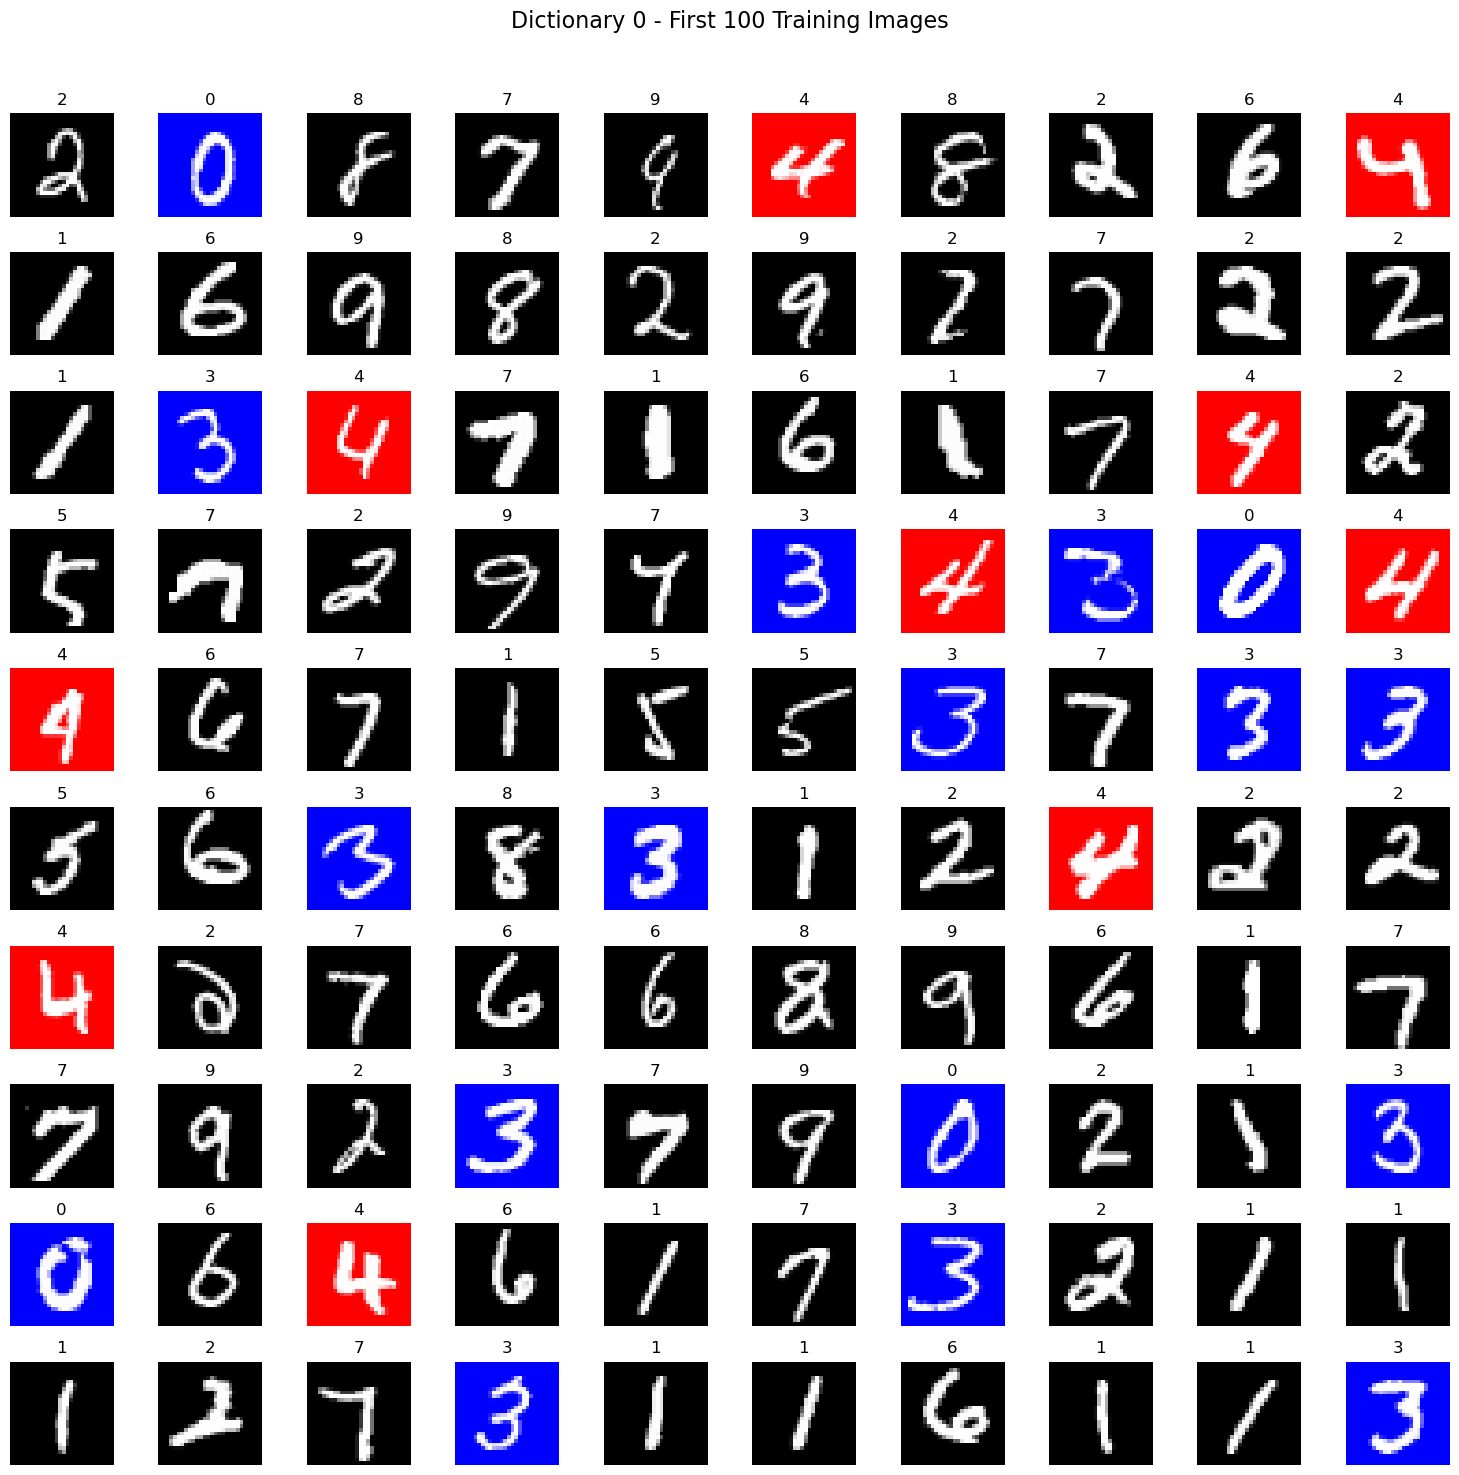

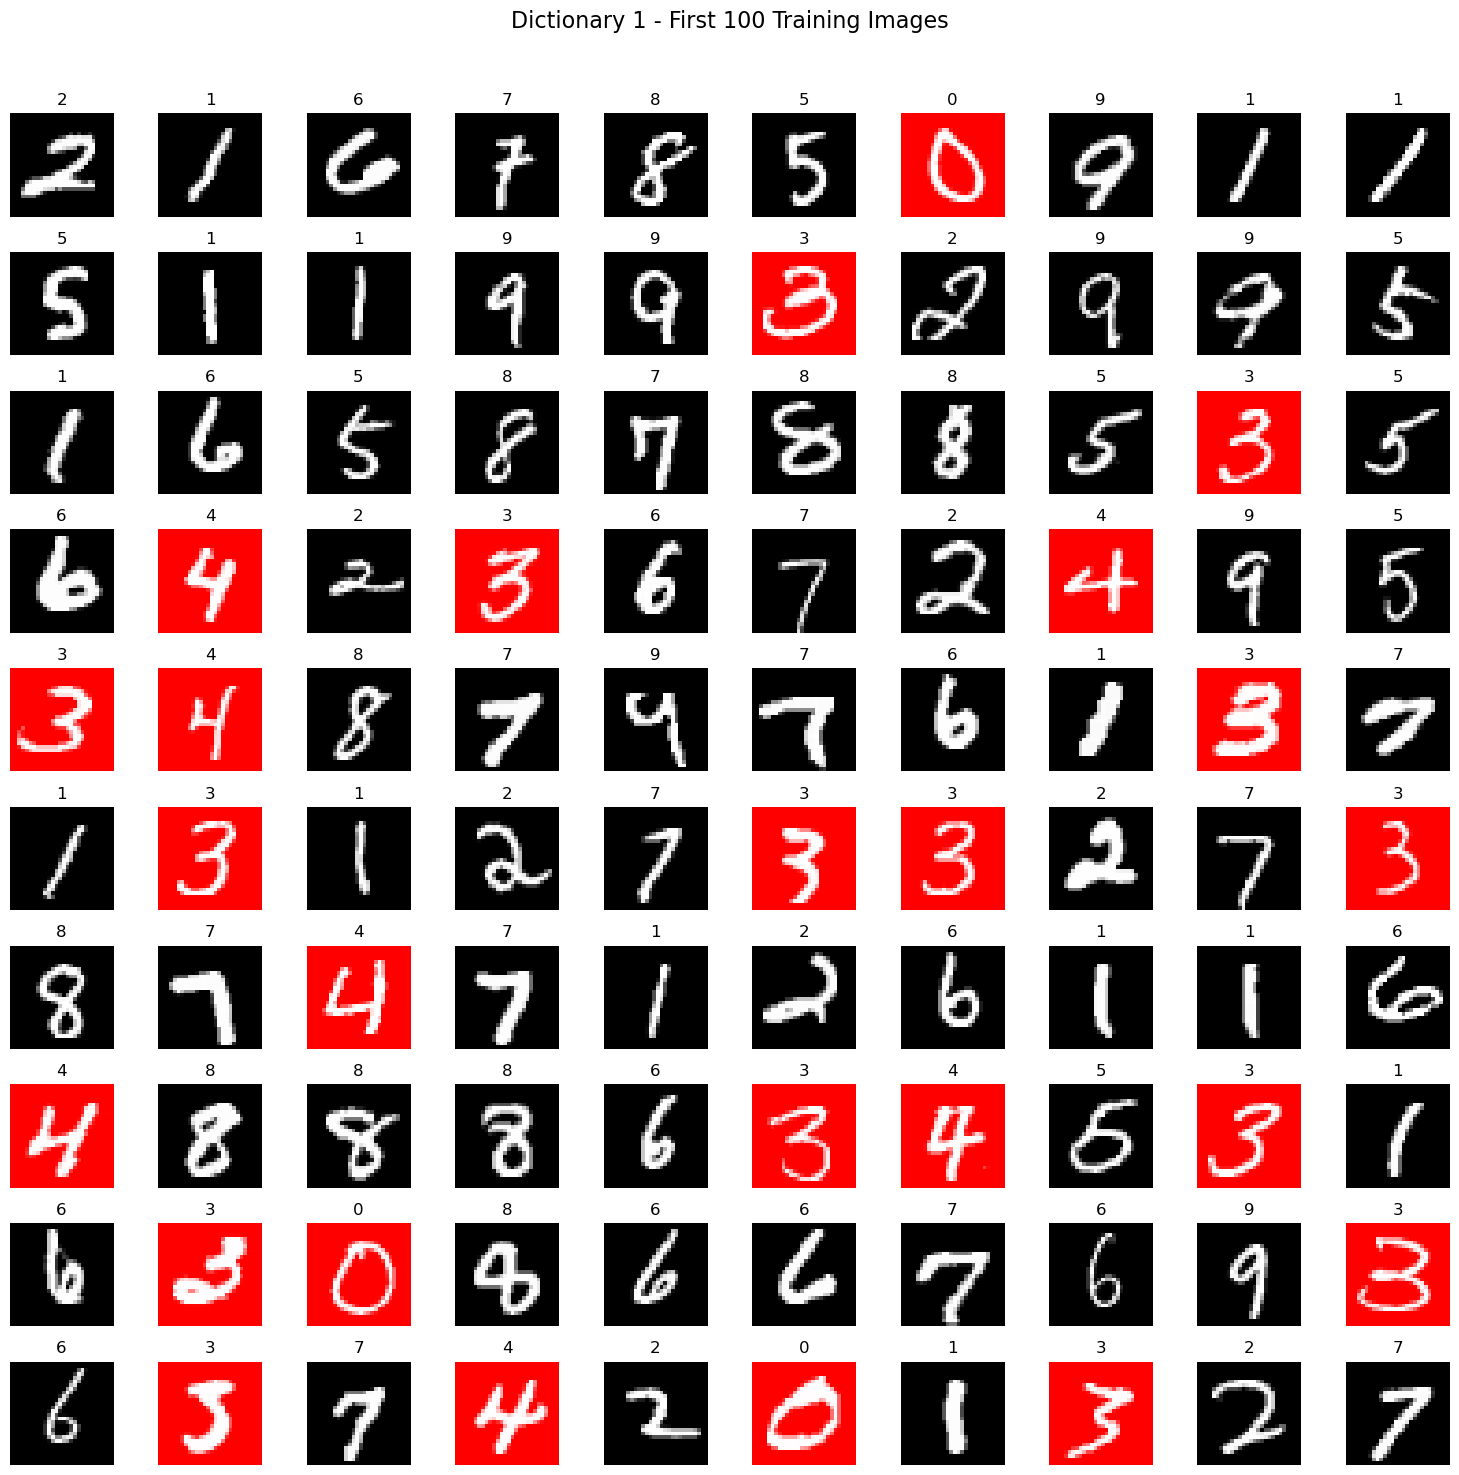

In [96]:
draw_split_statistic(rearranged_data, plot_indices=[0,1])

In [ ]:
import torch

# Set the random seed
torch.manual_seed(42)

# Generate a random permutation
perm1 = torch.randperm(10)
print("First permutation:", perm1)

# Set the random seed again to the same value
# torch.manual_seed(42)

# Generate the random permutation again
perm2 = torch.randperm(10)
print("Second permutation:", perm2)

# Check if the permutations are the same
print("Permutations are the same:", torch.equal(perm1, perm2))